### Problem statement
1.	Coding task: GIven the dataset of Taylor Swift songs, write a song generator that will continue writing a song given the first 2-3 verses in the style of the mentioned artist. Bonus point for generating album cover that can represent your song. 

### Data cleaning and preprocessing

In [ ]:
# Some of the files only have artists and song name and doesn't have any lyrics.
# To find files which doesn't have lyrics

import os

search_text = "Hearts Club Band" # replace with non lyrics text to search
parent_folder = "/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/Albums/"  

# Iterate through each subfolder and text file within the parent folder
for root, dirs, files in os.walk(parent_folder):
    for file_name in files:
        #print(file_name)
        file_path = os.path.join(root, file_name)
        with open(file_path, 'r') as file:
            content = file.read()
            if search_text in content:
                print(f"Found in file: {file_path}")



Found in file: /home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/Albums/SpeakNow_WorldTourLive/Rap_Unemployment.txt
Found in file: /home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/Albums/SpeakNow_WorldTourLive/WenchRench.txt


In [101]:
#FINAL CODE TO COMBINE THE LYRICS

import os
import re

# Path to the root directory containing the albums
root_dir = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/Albums/'

# Function to read lyrics from a .txt file
def read_lyrics_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Filter out lines with []
    lyrics = [re.sub(r'\[.*?\]', '', line).strip() for line in lines]
    lyrics = [line for line in lyrics if line and 'ContributorsTranslations' not in line]  # Exclude empty lines and lines with "ContributorsTranslations"
    
    # Remove numbers followed by "Embed"
    lyrics = [re.sub(r'\d+Embed', '', line) for line in lyrics]
    
    return lyrics

# Initialize an empty list to store the lyrics data
lyrics_data = []

# Iterate over the albums
for album in os.listdir(root_dir):
    album_dir = os.path.join(root_dir, album)
    
    # Check if the item is a directory
    if os.path.isdir(album_dir):
        # Iterate over the files in the album directory
        for file_name in os.listdir(album_dir):
            file_path = os.path.join(album_dir, file_name)
            
            # Check if the item is a file and has a .txt extension
            if os.path.isfile(file_path) and file_name.endswith('.txt'):
                # Read the lyrics from the .txt file
                lyrics = read_lyrics_from_file(file_path)
                
                # Append the lyrics to the lyrics_data list
                lyrics_data.append(lyrics)

# Save the lyrics_data list to a file
lyrics_data_file_path = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/lyrics_data5.txt' 
with open(lyrics_data_file_path, 'w') as file:
    for lyrics in lyrics_data:
        file.write('\n'.join(lyrics))
        #file.write('\n\n')

print('Lyrics data saved to:', lyrics_data_file_path)


Lyrics data saved to: /home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/lyrics_data5.txt


In [102]:
# Tried with smaller sequence and the loss was high so decided to make bigger sequence by combining 5 lines into one.

input_file = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/lyrics_data5.txt'  
output_file = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/comb5_lyrics_data5.txt'  

lines = []
combined_lines = []

# Read the input file
with open(input_file, 'r') as file:
    lines = file.readlines()

# Combine every five lines into one
for i in range(0, len(lines), 5):
    combined_line = ' '.join(lines[i:i+5]).replace('\n', '').strip()
    combined_lines.append(combined_line)

# Save the combined lines to the output file
with open(output_file, 'w') as file:
    file.write('\n'.join(combined_lines))

print('Combined lines saved to:', output_file)


Combined lines saved to: /home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/comb5_lyrics_data5.txt


In [103]:
# First sequence
combined_lines[0]

"Don't look at me, you got a girl at home And everybody knows that, everybody knows that, ah-ah Don't look at me, you got a girl at home And everybody knows that I don't even know her"

In [38]:
# Reading from final saved file
lyrics_data_file_path = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/comb5_lyrics_data5.txt'  
with open(lyrics_data_file_path, 'r') as file:
    lyrics_data = file.read().splitlines()

In [39]:
# checking the first sequence from the file
lyrics_data[0]

"Don't look at me, you got a girl at home And everybody knows that, everybody knows that, ah-ah Don't look at me, you got a girl at home And everybody knows that I don't even know her"

### Data analysis

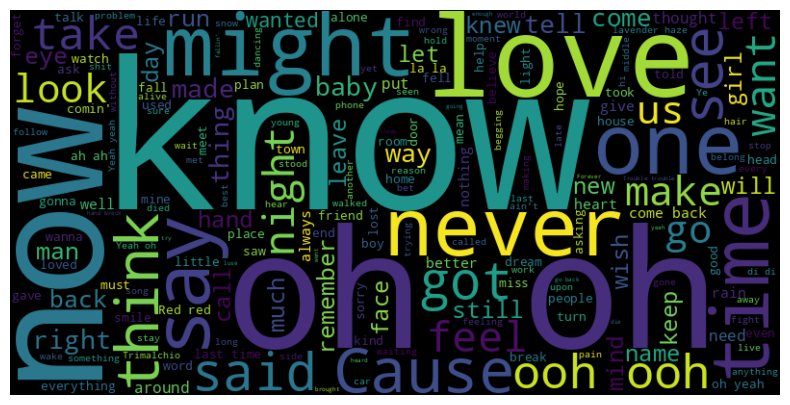

In [1]:
# There is imbalance in the data as shown below. Some words are used more frquently than others.
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Read the text file
text_file_path = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/comb5_lyrics_data5.txt'   
with open(text_file_path, 'r') as file:
    text = file.read()

# Create the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Modelling

In [1]:
# FINAL CODE FOR TRAINING

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential, load_model

# Load lyrics data from file
lyrics_data_file_path = '/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/comb5_lyrics_data5.txt'  
with open(lyrics_data_file_path, 'r') as file:
    lyrics_data = file.read().splitlines()

# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lyrics_data)

# Convert lyrics data to sequences
sequences = tokenizer.texts_to_sequences(lyrics_data)

# Pad sequences to have the same length
max_sequence_length = max([len(seq) for seq in sequences]) # 487
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='pre')

# Prepare input and target data
input_data = padded_sequences[:, :-1] #(5397, 486)
target_data = padded_sequences[:, -1] #(5397,)

# Split data into training and validation sets
input_train, input_val, target_train, target_val = train_test_split(input_data, target_data, test_size=0.1, random_state=42)

from imblearn.over_sampling import RandomOverSampler

# Count the occurrences of each target value
target_counts = np.bincount(target_train)

# Perform oversampling to balance the classes
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
input_train_balanced, target_train_balanced = oversampler.fit_resample(input_train, target_train)

# Reassign the balanced data to the training variables
input_train = input_train_balanced #(234732, 486)
target_train = target_train_balanced #(234732,)

# Define the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 512, input_length=max_sequence_length - 1))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# Define callbacks
checkpoint_filepath = "/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/models/model_chpt_Bidir32_loss_emb512_test_Drop0.5_test-{loss:.4f}_epoch-{epoch:02d}_{val_loss:.4f}.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True)

early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)
#model.load_weights("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/Test/actual_data/models/model_chpt_Bidir32_loss_emb512_test_Drop0.5-2.3074_epoch-02_6.6678.h5") 
model = load_model("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/extra_stuff/data/models/model_chpt_Bidir32_loss_emb512_test_Drop0.5-1.7061_epoch-01_6.6696.h5")

# Train the model
model.fit(input_train, target_train, validation_data=(input_val, target_val), epochs=2, callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/2
7336/7336 [==============================] - 818s 108ms/step - loss: 1.3669 - val_loss: 6.8119
Epoch 2/2
7336/7336 [==============================] - 682s 93ms/step - loss: 1.1798 - val_loss: 6.9246


In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 486, 512)          4163072   
                                                                 
 bidirectional (Bidirectiona  (None, 486, 64)          139520    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 486, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8131)              5

In [18]:
print(input_train.shape)
print(target_train.shape)
print(input_val.shape)
print(target_val.shape)


(234732, 486)
(234732,)
(540, 486)
(540,)


### Prediction

In [4]:
# Generate lyrics using the trained model
start_seed = "I should not be left"
num_words = 15

for _ in range(num_words):
    # Tokenize the input seed
    seed_sequence = tokenizer.texts_to_sequences([start_seed])[0]
    # Pad the seed sequence
    padded_seed = pad_sequences([seed_sequence], maxlen=max_sequence_length-1, padding='pre')
    # Generate the predicted word index
    predicted_probabilities = model.predict(padded_seed)[0]
    # Set the probability of the padding token to zero
    predicted_probabilities[0] = 0
    predicted_index = np.argmax(predicted_probabilities)
    # Update the seed sequence with the predicted word
    predicted_word = tokenizer.index_word.get(predicted_index, "<UNKNOWN>")
    start_seed += " " + predicted_word

print(start_seed)


1/1 [==============================] - 0s 60ms/step
I should not be left yeah yeah actually actually town town town town dark night night night ha red red
